# **Importing Libraries**

In [1]:
import os  # Used for interacting with the operating system, such as file path manipulations.
import pickle  # For serializing and deserializing Python object structures to and from files.
import numpy as np  # Fundamental package for scientific computing with Python, used for handling large, multi-dimensional arrays and matrices.
import matplotlib.pyplot as plt  # Plotting library to create static, interactive, and animated visualizations in Python.
from PIL import Image  # Python Imaging Library for opening, manipulating, and saving many different image file formats.
import warnings  # Used to control the display of warning messages.
warnings.filterwarnings('ignore')  # Ignores warnings, typically used to clean up output.
from math import ceil  # Imports the ceiling function to calculate the smallest integer greater than or equal to a given number.
from collections import defaultdict  # Imports defaultdict, a dictionary-like object that provides all methods provided by dictionary but takes a first argument as default data type for the dictionary.
from tqdm.notebook import tqdm  # A tool for creating progress meters or progress bars in Jupyter notebooks.

# Tensorflow and Keras imports
import tensorflow as tf  # TensorFlow, a library for numerical computation where computations are expressed as graphs.
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input  # Imports the VGG16 model, a pre-trained image recognition model, and a preprocessing function for proper input formatting.
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Tools for loading images and converting them into arrays.
from tensorflow.keras.preprocessing.text import Tokenizer  # Tool for text tokenization to convert raw text into an encoded format that can be used by machine learning models.
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Tool for padding sequences to the same length.
from tensorflow.keras.models import Model  # The basic class in Keras to create a model.
from tensorflow.keras.utils import to_categorical, plot_model  # Utilities for converting labels to categorical form and plotting the model architecture.
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda  # Various layers and functions for building neural network architectures.

from nltk.translate.bleu_score import corpus_bleu  # Library to calculate the BLEU score, a measure of how much the machine-generated text matches the human text.


In [2]:
pip install opendatasets

In [3]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/adityajn105/flickr8k")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ishak31
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k


100%|██████████| 1.04G/1.04G [00:06<00:00, 183MB/s]


In [4]:
# Setting the input and output directory
INPUT_DIR = 'flickr8k'

# **Image Features Extraction**

In [ ]:
# Load the vgg16 model
model = VGG16()

# Restructuring the model to remove the last classification layer, this will give us access to the output features of the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Printing the model summary
print(model.summary())

553467096/553467096 [==============================] - 18s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [5]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(INPUT_DIR, 'Images')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):
    # Load the image from file
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to a numpy array
    image = img_to_array(image)
    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for ResNet50
    image = preprocess_input(image)
    # Extract features using the pre-trained ResNet50 model
    image_feature = model.predict(image, verbose=0)
    # Get the image ID by removing the file extension
    image_id = img_name.split('.')[0]
    # Store the extracted feature in the dictionary with the image ID as the key
    image_features[image_id] = image_feature

  0%|          | 0/8091 [00:00<?, ?it/s]

NameError: name 'model' is not defined

In [6]:
OUTPUT_DIR = '/content'

In [ ]:
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

In [7]:
# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

# **Loading Caption Data**

In [8]:
with open(os.path.join(INPUT_DIR, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [9]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption using defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/40456 [00:00<?, ?it/s]

Total number of captions: 40455


# **Preprocessing Captions**

In [10]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

['A black dog carries a green toy in his mouth as he walks through the grass .',
 'A black dog carrying something through the grass .',
 'A black dog has a blue toy in its mouth .',
 'A dog in grass with a blue item in his mouth .',
 'A wet black dog is carrying a green toy through the grass .']

In [12]:
# preprocess the text
clean(image_to_captions_mapping)

In [13]:
# after preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

['startseq black dog carries green toy in his mouth as he walks through the grass endseq',
 'startseq black dog carrying something through the grass endseq',
 'startseq black dog has blue toy in its mouth endseq',
 'startseq dog in grass with blue item in his mouth endseq',
 'startseq wet black dog is carrying green toy through the grass endseq']

In [14]:
# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [18]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [19]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 8768
Maximum Caption Length: 34


# **Train Test Split**

In [20]:
# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# Data generator function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    # Lists to store batch data
    X1_batch, X2_batch, y_batch = [], [], []
    # Counter for the current batch size
    batch_count = 0

    while True:
        # Loop through each image in the current batch
        for image_id in data_keys:
            # Get the captions associated with the current image
            captions = image_to_captions_mapping[image_id]

            # Loop through each caption for the current image
            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                # Loop through the tokens in the caption sequence
                for i in range(1, len(caption_seq)):
                    # Split the sequence into input and output pairs
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Pad the input sequence to the specified maximum caption length
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]

                    # Convert the output sequence to one-hot encoded format
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append data to batch lists
                    X1_batch.append(features[image_id][0])  # Image features
                    X2_batch.append(in_seq)  # Input sequence
                    y_batch.append(out_seq)  # Output sequence

                    # Increase the batch counter
                    batch_count += 1

                    # If the batch is complete, yield the batch and reset lists and counter
                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield [X1_batch, X2_batch], y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

# **LSTM Model Training**

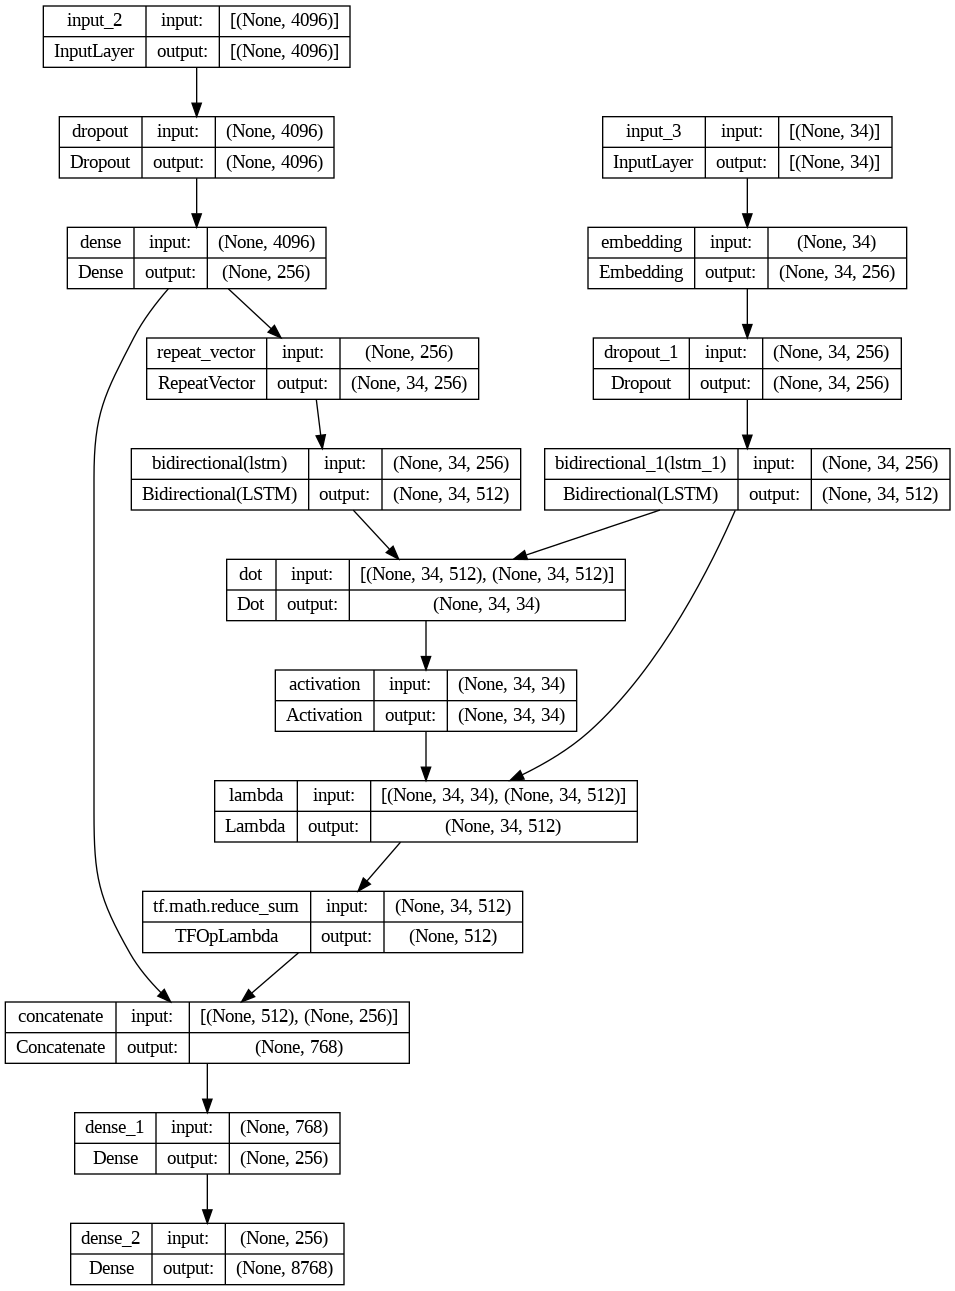

In [ ]:
# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calculate attention scores

# Softmax attention scores
attention_scores = Activation('softmax')(attention)

# Apply attention scores to sequence embeddings
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

# Sum the attended sequence embeddings along the time axis
context_vector = tf.reduce_sum(attention_context, axis=1)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model
plot_model(model, show_shapes=True)

In [ ]:
# Set the number of epochs, batch size
epochs = 50
batch_size = 32

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  # Calculate the steps for validation data

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)

    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
          validation_data=test_generator, validation_steps=validation_steps,
          verbose=1)

Epoch 1/50
228/228 [==============================] - 221s 867ms/step - loss: 6.4457 - val_loss: 6.4230
Epoch 2/50
228/228 [==============================] - 184s 805ms/step - loss: 5.2777 - val_loss: 6.3138
Epoch 3/50
228/228 [==============================] - 181s 793ms/step - loss: 4.8132 - val_loss: 6.6939
Epoch 4/50
228/228 [==============================] - 189s 828ms/step - loss: 4.5977 - val_loss: 6.5867
Epoch 5/50
228/228 [==============================] - 190s 832ms/step - loss: 4.2975 - val_loss: 6.6360
Epoch 6/50
228/228 [==============================] - 183s 802ms/step - loss: 3.9543 - val_loss: 6.9639
Epoch 7/50
228/228 [==============================] - 183s 803ms/step - loss: 3.6368 - val_loss: 6.3491
Epoch 8/50
228/228 [==============================] - 183s 804ms/step - loss: 3.4334 - val_loss: 6.7531
Epoch 9/50
228/228 [==============================] - 181s 794ms/step - loss: 3.1336 - val_loss: 6.6981
Epoch 10/50
228/228 [==============================] - 183s 801m

In [ ]:
# Save the model
model.save(OUTPUT_DIR+'/mymodel.h5')

In [22]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('mymodel.h5')


# **Captions Generation**

In [23]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [24]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Initialize the caption sequence
    caption = 'startseq'

    # Generate the caption
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)

        # Append the predicted word to the caption
        caption += " " + predicted_word

        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break

    return caption

In [25]:
# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_captions_mapping[key]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)

    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()

    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU scores
bleu1 = corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0))
bleu2 = corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.33, 0.33, 0.33, 0))
bleu4 = corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.25, 0.25, 0.25, 0.25))

print("BLEU-1: %f" % bleu1)
print("BLEU-2: %f" % bleu2)
print("BLEU-3: %f" % bleu3)
print("BLEU-4: %f" % bleu4)

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.431683
BLEU-2: 0.193122
BLEU-3: 0.099095
BLEU-4: 0.048306


In [27]:
pip install git+https://github.com/salaniz/pycocoevalcap

  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-_7rkp825
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-_7rkp825
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312246 sha256=15b1fab0fa842e7ec1d5c2c15ba80d0aea17cf3618030ae91b2752b3bc2d02bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-k44p2wp1/wheels/43/54/73/3e2c6d4ace7657958cde52ac6fd47b342cd4aae5a7aa4fcbf9
Successfully built pycocoevalcap


In [28]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

In [29]:
# Create a dictionary of generated and reference captions
gen = {i: [' '.join(pred)] for i, pred in enumerate(predicted_captions_list)}
ref = {i: [' '.join(act) for act in acts] for i, acts in enumerate(actual_captions_list)}

# Initialize evaluation objects
bleu_scorer = Bleu(4)
meteor_scorer = Meteor()
rouge_scorer = Rouge()
cider_scorer = Cider()
spice_scorer = Spice()

# Evaluate
bleu_score, _ = bleu_scorer.compute_score(ref, gen)
meteor_score, _ = meteor_scorer.compute_score(ref, gen)
rouge_score, _ = rouge_scorer.compute_score(ref, gen)
cider_score, _ = cider_scorer.compute_score(ref, gen)
spice_score, _ = spice_scorer.compute_score(ref, gen)

print(f'BLEU-1: {bleu_score[0]}')
print(f'BLEU-2: {bleu_score[1]}')
print(f'BLEU-3: {bleu_score[2]}')
print(f'BLEU-4: {bleu_score[3]}')
print(f'METEOR: {meteor_score}')
print(f'ROUGE: {rouge_score}')
print(f'CIDEr: {cider_score}')
print(f'SPICE: {spice_score}')

Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
{'testlen': 9595, 'reflen': 8912, 'guess': [9595, 8785, 7975, 7165], 'correct': [4142, 759, 194, 43]}
ratio: 1.0766382405743855
BLEU-1: 0.43168316831678666
BLEU-2: 0.1931223612495877
BLEU-3: 0.09680817980996693
BLEU-4: 0.04830555832666551
METEOR: 0.17778194432957967
ROUGE: 0.38249932532033
CIDEr: 0.116762859824469
SPICE: 0.10194627813578379


# **Predicting captions for Images**

In [ ]:
# Function for generating caption
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq man skis past another man displaying paintings in the snow endseq


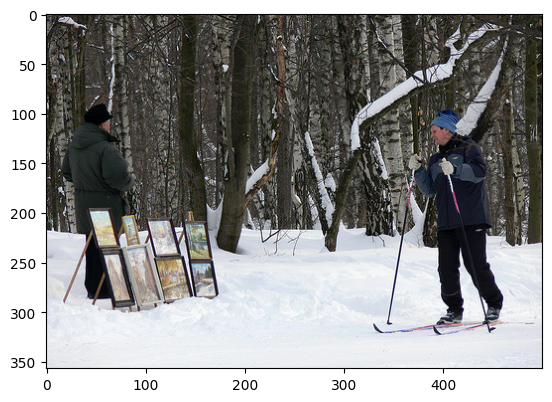

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq there is girl with pigtails sitting in front of rainbow painting endseq


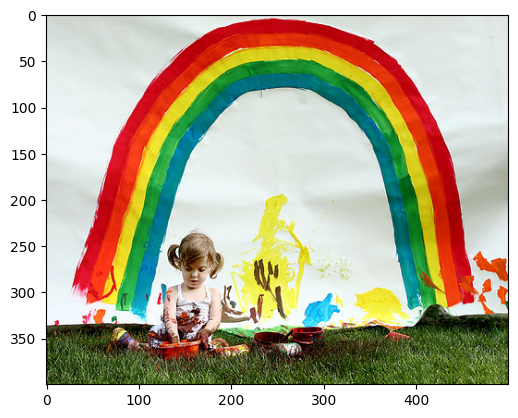

In [ ]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq
--------------------Predicted--------------------
startseq man is skyscraper in the distance and woman walking in front of the camera endseq


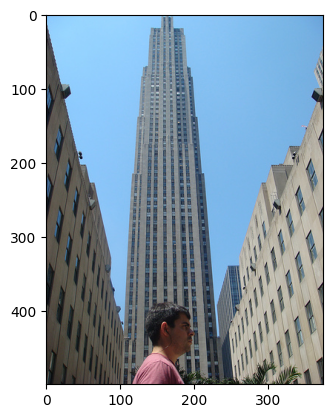

In [ ]:
generate_caption("1032460886_4a598ed535.jpg")

In [ ]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

553467096/553467096 [==============================] - 18s 0us/step


In [ ]:
image_path = 'hello3.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_caption_length)

'startseq two dogs are running in the of the of the endseq'

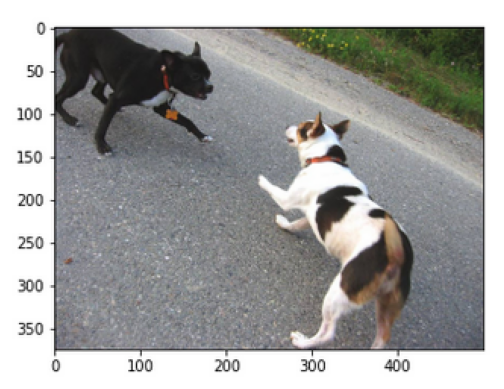

In [ ]:
import matplotlib.image as mpimg

img = mpimg.imread('hello3.jpg')

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()